# Identifying deforestation using CNNs

Using a variety of deep learning techniques, including transfer learning, to classify satellite images of the Amazon rainforest

## Preparing the data

We are given a folder with 40000+ satellite images and a corresponding csv file with the appropriate labels. In the following cell we will construct our dataframe, which consist of the appropriate labels and their respective file paths.

In [1]:
import numpy as np
from sklearn.datasets import load_files
from sklearn import preprocessing
from keras.utils import np_utils
from glob import glob
import pandas as pd
import re
from IPython.display import display

def load_data_files(path):
    data = load_files(path)
    filenames = np.array(data['filenames'])
    return filenames

def add_numerical(df):
    numerical = []
    for index, row in df.iterrows():
        numerical.append(re.sub("[^0-9]", "", row['filepath']))
        
    df['id'] = pd.Series(numerical).values
    return df
    
total_files = load_data_files('../data/train')
df = pd.DataFrame(np.hstack((total_files)))
df.columns = ['filepath']
df = add_numerical(df)
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df = df.sort_values('id', ascending=True)
df.set_index('id', inplace=True)

csv_data = pd.read_csv('../data/labels.csv', na_filter=False)

df['image_name'] = pd.Series(csv_data['image_name'])
df['tags'] = pd.Series(csv_data['tags'])

display(df.head())

Using TensorFlow backend.


,filepath,image_name,tags
id,,,
0,../data/train/train-jpg/train_0.jpg,train_0,haze primary
1,../data/train/train-jpg/train_1.jpg,train_1,agriculture clear primary water
2,../data/train/train-jpg/train_2.jpg,train_2,clear primary
3,../data/train/train-jpg/train_3.jpg,train_3,clear primary
4,../data/train/train-jpg/train_4.jpg,train_4,agriculture clear habitation primary road


After forming our dataframe, we will one-hot encode the labels. 


In [2]:
total_classes = ['agriculture', 'bare_ground', 'blooming', 'blow_down', 'clear',
    'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy',
    'primary', 'road', 'selective_logging', 'slash_burn', 'water', 'cloudy', 'artisinal_mine']

def constructLabelVector(dataFrame):
    result_vector = []
    for index, row in dataFrame.iterrows():
        pos = findPositionsWithinClasses(row['tags'])
        vector = createVector(pos)
        result_vector.append(vector)
    
    return result_vector
        
def findPositionsWithinClasses(string):
    positions = []
    list_strings = string.split()
    for word in list_strings:
        index = total_classes.index(word)
        positions.append(index)
        
    return positions
        
def createVector(pos):
    vector = []
    for i in range(len(total_classes)):
        if i in pos:
            vector.append(1)
        else:
            vector.append(0)
    
    return vector
            
targets = np.array(constructLabelVector(df))

print('There are %d labels in total.' % len(targets))

There are 40479 labels in total.


Splitting the data into training, validation and testing sets. This will consist of the filepaths and their respective multi-label vectors. We will split the total data in training and testing sets at a 80/20 ratio and then split the training data into training and validation sets at a 80/20 ratio.

In [3]:
total_files = np.array(df['filepath'])

print('There are %d images in total.' % len(total_files))

def splitFiles(files, targets):
    length = len(files)
    split_point = int(round(length * 0.8))
    return files[:split_point], targets[:split_point], files[split_point:], targets[split_point:]
    
train_valid_files, train_valid_targets, test_files, test_targets = splitFiles(total_files, targets)

train_files, train_targets, valid_files, valid_targets = splitFiles(train_valid_files, train_valid_targets)

print(len(train_files) + len(valid_files) + len(test_files))

print('There are %d training images in total.' % len(train_files))
print('There are %d validation images in total.' % len(valid_files))
print('There are %d testing images in total.' % len(test_files))


There are 40479 images in total.
40479
There are 25906 training images in total.
There are 6477 validation images in total.
There are 8096 testing images in total.


Showing some of the training images and their respective labels

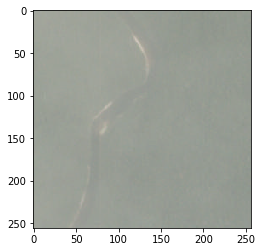

['haze', 'primary', 'water']


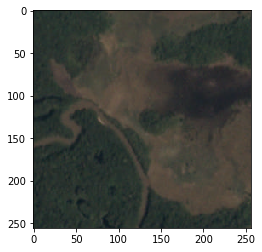

['agriculture', 'clear', 'primary', 'slash_burn', 'water']


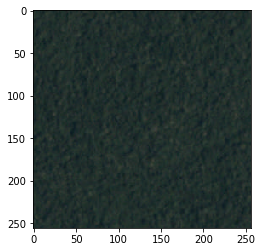

['clear', 'primary']


In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

def showImage(num_list):
    for num in num_list:
        img = cv2.imread(train_files[num])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print(convertBackToLabels(train_targets[num]))

def convertBackToLabels(array):
    tags = []
    list_values = array.tolist()
    for i in range(len(list_values)):
        if list_values[i] == 1:
            tags.append(total_classes[i])
    
    return tags
        
showImage([5, 10, 15])


## Building CNN from scratch

In this section we will build a CNN from scratch. We will try out a number of different parameters and architectures in order to maximize for accuracy and the F2 score. We will also compare our result with our benchmark model here.

Preprocessing image data and return 4D tensors for every image (Keras requires 4D array as input), then we will rescale the images before using them in our CNN.


In [5]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale our images by dividing every pixel in every image by 255

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 8096/8096 [00:15<00:00, 523.04it/s]


The next code block buildings a CNN using Keras

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=20, kernel_size=3, padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=40, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=80, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(len(total_classes), activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 20)      560       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 40)      7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 40)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 80)        28880     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 80)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 80)        0         
__________

#### Compiling the model

In [8]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

#### Training the model

In [ ]:
epochs = 8

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_original.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


#### Load and test the model
We will use the evaluation metrics precision, recall and f-beta score, with beta = 2

In [9]:
model.load_weights('saved_models/weights.best.from_original.hdf5')

from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def predictImage(selected_model):
    predictions = []
    for tensor in test_tensors:
        result = selected_model.predict(np.expand_dims(tensor, axis=0))
        preds = result[0]
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0 
        predictions.append(preds)

    return predictions

first_predictions = np.array(predictImage(model)).astype(int)

print(first_predictions[:3])
print(test_targets[:3])

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


In [10]:
model_recall_score = recall_score(test_targets, first_predictions, average='weighted')
model_precision_score = precision_score(test_targets, first_predictions, average='weighted')
model_fbeta_score = fbeta_score(test_targets, first_predictions, average='weighted', beta=2)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('Fbeta score:', model_fbeta_score)

Recall score: 0.689031204333
Precision score: 0.816829522145
Fbeta score: 0.699769182138


/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Benchmark Model
In this section we'd like to define a benchmark model which we will compare our trained models to. The benchmark model will be randomly guessing labels.

In [12]:
import random

def generateRandomLabels():
    num_labels = random.randint(1, 5)
    prediction_list = []
    for i in range(len(test_targets)):
        prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for j in range(num_labels):
            index = random.randint(0, 16)
            prediction[index] = 1
        
        prediction_list.append(prediction)
        
    return prediction_list

random_predictions = np.array(generateRandomLabels())

#print(random_predictions[:5])
random_recall_score = recall_score(test_targets, random_predictions, average='weighted')
random_precision_score = precision_score(test_targets, random_predictions, average='weighted')
random_fbeta_score = fbeta_score(test_targets, random_predictions, average='weighted', beta=2)

print('Random recall score:', random_recall_score)
print('Random precision score:', random_precision_score)
print('Random fbeta score:', random_fbeta_score)
        

Random recall score: 0.267213960285
Random precision score: 0.556780792377
Random fbeta score: 0.274807373286


## Transfer Learning - Resnet50
In this following section, we want to use transfer learning on state of the art CNN architectures

In [11]:
from keras.layers import *
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

#nb_classes = len(total_classes)
#based_model_last_block_layer_number = 126
nb_classes = 17
img_width, img_height = 256, 256
batch_size = 32
nb_epoch = 50
learn_rate = 1e-4  #sgd learning rate
momentum = .9

base_model_Resnet50 = ResNet50(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')

def build_ResNet50_shallow():
    x = base_model_Resnet50.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='sigmoid')(x)

    model = Model(base_model_Resnet50.input, predictions)
    
    #freeze pretrained base layers
    for layer in base_model_Resnet50.layers:
        layer.trainable = False
        
    #print(model.summary())
    return model
    
def build_ResNet50_deep():
    x = base_model_Resnet50.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='sigmoid')(x)

    model = Model(base_model_Resnet50.input, predictions)
    
    for layer in model.layers[:26]:
        layer.trainable = False
    for layer in model.layers[26:]:
        layer.trainable = True
        
    #print(model.summary())
    return model

model_ResNet50_shallow = build_ResNet50_shallow()
model_ResNet50_deep = build_ResNet50_deep()
    

Next step, we train the new model based on the Resnet50 model. The shallow model is where we retrain only the top layer while the deep model we retrain lower layers. 

In [12]:
def train_ResNet50(model, shallow, epochs):
    sgd = SGD(lr=learn_rate, decay=1e-6, momentum=momentum, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    if shallow == True:
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50_shallow.hdf5', 
                               verbose=1, save_best_only=True)
    else:
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50_deep.hdf5', 
                               verbose=1, save_best_only=True)

    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
    
    return model

In [ ]:
trained_ResNet50_shallow = train_ResNet50(model_ResNet50_shallow, True, 8)

In [14]:
model_ResNet50_shallow.load_weights('saved_models/weights.best.ResNet50_shallow.hdf5')
ResNet50_shallow_predictions = np.array(predictImage(model_ResNet50_shallow)).astype(int)

model_recall_score = recall_score(test_targets, ResNet50_shallow_predictions, average='weighted')
model_precision_score = precision_score(test_targets, ResNet50_shallow_predictions, average='weighted')
model_fbeta_score = fbeta_score(test_targets, ResNet50_shallow_predictions, average='weighted', beta=2)

print('ResNet50_shallow_predictions Recall score:', model_recall_score)
print('ResNet50_shallow_predictions Precision score:', model_precision_score)
print('ResNet50_shallow_predictions Fbeta score:', model_fbeta_score)
    

ResNet50_shallow_predictions Recall score: 0.787715980401
ResNet50_shallow_predictions Precision score: 0.853888127548
ResNet50_shallow_predictions Fbeta score: 0.794536245516


/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
trained_ResNet50_deep = train_ResNet50(model_ResNet50_deep, False, 25)

Train on 25906 samples, validate on 6477 samples
Epoch 1/25
25906/25906 [==============================] - 1029s - loss: 0.3666 - acc: 0.8625 - val_loss: 0.3799 - val_acc: 0.8512
Epoch 2/25
25906/25906 [==============================] - 1016s - loss: 0.2116 - acc: 0.9267 - val_loss: 0.1884 - val_acc: 0.9328
Epoch 3/25
25906/25906 [==============================] - 1016s - loss: 0.1833 - acc: 0.9338 - val_loss: 0.1698 - val_acc: 0.9386
Epoch 4/25
25906/25906 [==============================] - 1016s - loss: 0.1686 - acc: 0.9385 - val_loss: 0.1589 - val_acc: 0.9421
Epoch 5/25
25906/25906 [==============================] - 1018s - loss: 0.1593 - acc: 0.9411 - val_loss: 0.1513 - val_acc: 0.9446
Epoch 6/25
25906/25906 [==============================] - 1018s - loss: 0.1523 - acc: 0.9437 - val_loss: 0.1455 - val_acc: 0.9465
Epoch 7/25
25906/25906 [==============================] - 1016s - loss: 0.1466 - acc: 0.9456 - val_loss: 0.1408 - val_acc: 0.9482
Epoch 8/25
25906/25906 [=================

In [15]:
model_ResNet50_deep.load_weights('saved_models/weights.best.ResNet50_deep.hdf5')
ResNet50_deep_predictions = np.array(predictImage(model_ResNet50_deep)).astype(int)

model_recall_score = recall_score(test_targets, ResNet50_deep_predictions, average='weighted')
model_precision_score = precision_score(test_targets, ResNet50_deep_predictions, average='weighted')
model_fbeta_score = fbeta_score(test_targets, ResNet50_deep_predictions, average='weighted', beta=2)

print('ResNet50_deep_predictions Recall score:', model_recall_score)
print('ResNet50_deep_predictions Precision score:', model_precision_score)
print('ResNet50_deep_predictions Fbeta score:', model_fbeta_score)

ResNet50_deep_predictions Recall score: 0.831470815783
ResNet50_deep_predictions Precision score: 0.892577069467
ResNet50_deep_predictions Fbeta score: 0.839152003354


/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
